# RFM Segmentation Refinement

## The Problem
**45% of our customers are labeled "Others"** — this is too vague for targeted marketing!

## The Goal
Reduce "Others" to less than 20% by creating better customer segments.

## What We'll Do
Test 3 different ways to group customers better:
1. **Better Rules** — Add more specific customer categories
2. **Machine Learning** — Let the data find natural groups
3. **Mix of Both** — Combine rules + ML


In [2]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")
pd.options.display.float_format = '{:.2f}'.format


---
## Step 1: See the Current Problem


In [4]:
# Load the customer data with RFM scores
rfm = pd.read_csv("../data/processed/rfm_scores.csv")

# Count how many customers in each segment
current_segments = rfm['segment'].value_counts()
current_percent = (current_segments / len(rfm) * 100).round(1)

print(f"We have {len(rfm):,} total customers\n")
print("Current segments:")
for segment, count in current_segments.items():
    pct = current_percent[segment]
    print(f"  {segment:20s}: {count:>7,} customers ({pct:>5.1f}%)")
    
print(f"\n❌ Problem: {current_percent['Others']:.1f}% are in 'Others'")
print(f"   Goal: Get this below 20%")


We have 879,358 total customers

Current segments:
  Others              : 350,347 customers ( 39.8%)
  Loyal               : 138,260 customers ( 15.7%)
  Need Attention      : 119,257 customers ( 13.6%)
  Potential Loyalists : 118,111 customers ( 13.4%)
  Champions           :  85,382 customers (  9.7%)
  At Risk             :  68,001 customers (  7.7%)

❌ Problem: 39.8% are in 'Others'
   Goal: Get this below 20%


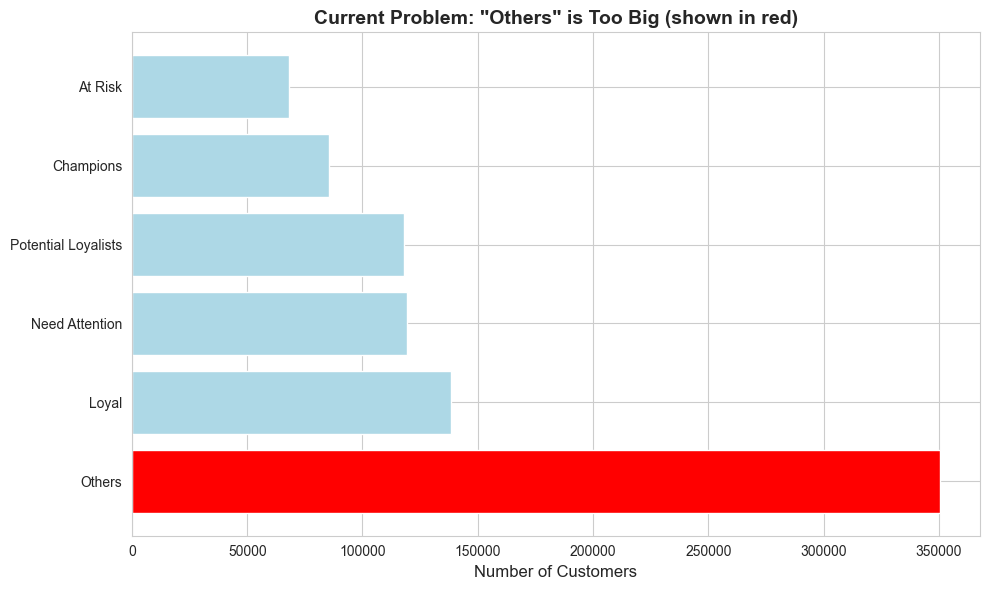

In [3]:
# Visualize: See how big "Others" is
colors = ['red' if seg == 'Others' else 'lightblue' for seg in current_segments.index]

plt.figure(figsize=(10, 6))
plt.barh(current_segments.index, current_segments.values, color=colors)
plt.xlabel('Number of Customers', fontsize=12)
plt.title('Current Problem: "Others" is Too Big (shown in red)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
## Solution 1: Add More Specific Categories

**The Idea:** Instead of 6 vague groups, create 11 specific ones.

**New categories we'll add:**
- 🆕 **Recent Customers** — Just made their first purchase
- 🌟 **Promising** — New customers spending good money
- ⚠️ **Can't Lose Them** — Big spenders who stopped coming
- 😴 **About to Sleep** — Activity is dropping
- 💤 **Hibernating** — Haven't been back in a long time


In [4]:
# Create better categories
def better_categories(row):
    # Get the customer's RFM scores (1-5 scale)
    recency = row['R_score']    # How recently they bought (5=very recent)
    frequency = row['F_score']  # How often they buy (5=very often)
    monetary = row['M_score']   # How much they spend (5=big spender)
    
    # Keep the good segments we already have
    if recency >= 4 and frequency >= 4 and monetary >= 4:
        return "Champions"  # Our best customers!
    
    if recency >= 4 and frequency >= 3:
        return "Loyal"  # Come back often
    
    if recency >= 3 and frequency >= 2 and monetary >= 3:
        return "Potential Loyalists"  # Could become Champions
    
    # NEW: Add specific categories for different situations
    if recency == 5 and frequency <= 2:
        return "Recent Customers"  # Just joined us
    
    if recency >= 4 and frequency <= 2 and monetary >= 3:
        return "Promising"  # New but spending well
    
    if recency <= 2 and monetary >= 4:
        return "Can't Lose Them"  # Big spenders going away!
    
    if recency <= 2 and frequency >= 4:
        return "Needs Attention"  # Used to come a lot
    
    if recency <= 2 and frequency <= 2 and monetary <= 2:
        return "At Risk"  # Low everything
    
    if recency == 3 and frequency <= 2 and monetary <= 2:
        return "About to Sleep"  # Declining
    
    if recency == 1:
        return "Hibernating"  # Gone for a while
    
    return "Others"  # Everyone else

# Apply the new categories
rfm['better_segments'] = rfm.apply(better_categories, axis=1)

print("✅ Created better categories!")


✅ Created better categories!


In [5]:
# Check the results
new_segments = rfm['better_segments'].value_counts()
new_percent = (new_segments / len(rfm) * 100).round(1)

print("Solution 1 Results:")
for segment, count in new_segments.items():
    pct = new_percent[segment]
    print(f"  {segment:20s}: {count:>7,} customers ({pct:>5.1f}%)")

others_now = new_percent.get('Others', 0)
print(f"\n✅ Others is now: {others_now:.1f}%")
print(f"   We reduced it by: {current_percent['Others'] - others_now:.1f} percentage points!")

if others_now < 20:
    print("   🎉 SUCCESS! We hit our goal!")


Solution 1 Results:
  Loyal               : 138,260 customers ( 15.7%)
  Can't Lose Them     : 132,985 customers ( 15.1%)
  Others              : 126,670 customers ( 14.4%)
  Potential Loyalists : 118,111 customers ( 13.4%)
  Champions           :  85,382 customers (  9.7%)
  Needs Attention     :  68,462 customers (  7.8%)
  At Risk             :  68,001 customers (  7.7%)
  Recent Customers    :  46,601 customers (  5.3%)
  Hibernating         :  43,030 customers (  4.9%)
  About to Sleep      :  33,269 customers (  3.8%)
  Promising           :  18,587 customers (  2.1%)

✅ Others is now: 14.4%
   We reduced it by: 25.4 percentage points!
   🎉 SUCCESS! We hit our goal!


---
## Solution 2: Use Machine Learning to Find Groups

**The Idea:** Let the computer find natural groups in the data instead of using rules.

We'll use **KMeans** — it's like asking the computer: *"Can you organize these 880,000 customers into groups that are similar to each other?"*

**How it works:**
1. Convert customer data to numbers the computer can use
2. Test different numbers of groups (3, 4, 5, etc.)
3. Pick the best number using a "quality score"
4. Give each group a business-friendly name


In [5]:
# Step 1: Prepare data for machine learning
# ML needs numbers on the same scale (like converting feet and inches to just inches)

scaler = StandardScaler()
customer_data = rfm[['recency_days', 'frequency', 'monetary']]
scaled_data = scaler.fit_transform(customer_data)

print("✅ Data prepared for machine learning!")
print(f"   Using 3 features: Recency, Frequency, Monetary")
print(f"   Total customers: {len(rfm):,}")


✅ Data prepared for machine learning!
   Using 3 features: Recency, Frequency, Monetary
   Total customers: 879,358


In [ ]:
# Step 2: Find the best number of groups
# We'll test 3 to 10 groups and see which works best

print("Testing different numbers of groups...\n")

scores = []
for num_groups in range(3, 11):
    # Create groups
    kmeans = KMeans(n_clusters=num_groups, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    
    # Calculate quality score (higher = better)
    score = silhouette_score(scaled_data, labels, sample_size=10000)
    scores.append(score)
    
    print(f"  {num_groups} groups: Quality score = {score:.3f}")

# Find the best
best_num = range(3, 11)[scores.index(max(scores))]
print(f"\n🎯 Best number of groups: {best_num}")
print(f"   This gives us the highest quality score: {max(scores):.3f}")


Testing different numbers of groups...

  3 groups: Quality score = 0.532


In [ ]:
# Step 3: Create the final groups
kmeans = KMeans(n_clusters=best_num, random_state=42, n_init=20)
rfm['ml_group'] = kmeans.fit_predict(scaled_data)

# See what each group looks like
group_summary = rfm.groupby('ml_group').agg({
    'recency_days': 'mean',
    'frequency': 'mean', 
    'monetary': 'mean',
    'CustomerID': 'count'
}).round(1)

group_summary.columns = ['Avg Days Since Purchase', 'Avg Purchases', 'Avg Spent (₹)', 'Customers']

print("\nWhat each ML group looks like:")
print(group_summary.sort_values('Customers', ascending=False))


In [ ]:
# Step 4: Give each group a meaningful name
def name_ml_group(group_num):
    """Give business-friendly names based on group characteristics"""
    stats = group_summary.loc[group_num]
    
    avg_recency = stats['Avg Days Since Purchase']
    avg_frequency = stats['Avg Purchases']
    avg_monetary = stats['Avg Spent (₹)']
    
    # Name based on behavior
    if avg_recency < 30 and avg_frequency > 1.5 and avg_monetary > 3000:
        return f"Champions (Group {group_num})"
    elif avg_monetary > 5000:
        return f"High Spenders (Group {group_num})"
    elif avg_recency < 35 and avg_frequency > 1.3:
        return f"Loyal (Group {group_num})"
    elif avg_recency > 60:
        return f"Inactive (Group {group_num})"
    elif avg_recency < 40:
        return f"Active (Group {group_num})"
    else:
        return f"Standard (Group {group_num})"

# Apply names
rfm['ml_segments'] = rfm['ml_group'].apply(name_ml_group)

# Count
ml_segments = rfm['ml_segments'].value_counts()
ml_percent = (ml_segments / len(rfm) * 100).round(1)

print("\nSolution 2 Results:")
for segment, count in ml_segments.items():
    pct = ml_percent[segment]
    print(f"  {segment:25s}: {count:>7,} customers ({pct:>5.1f}%)")

print(f"\n✅ No 'Others' category — every customer has a meaningful group!")
print(f"   Machine learning assigned 100% of customers")


---
## Solution 3: Mix Rules + Machine Learning

**The Idea:** Keep the important groups from our rules, use ML for the rest.

**How it works:**
1. Keep our most important groups: Champions, Loyal, At Risk, etc.
2. Take everyone else and use ML to organize them
3. This gives us both clarity (for important groups) and precision (for the middle)


In [ ]:
# Step 1: Decide which groups to keep as-is
important_groups = ['Champions', 'Loyal', 'At Risk', 'Needs Attention', "Can't Lose Them"]

# Find customers NOT in these important groups
needs_sorting = ~rfm['better_segments'].isin(important_groups)

print(f"Keeping these important groups as-is: {important_groups}")
print(f"\nWill use ML to organize: {needs_sorting.sum():,} customers ({needs_sorting.sum()/len(rfm)*100:.1f}%)")


In [ ]:
# Step 2: Use ML on the remaining customers
remaining_data = rfm.loc[needs_sorting, ['recency_days', 'frequency', 'monetary']]
remaining_scaled = scaler.fit_transform(remaining_data)

# Create 6 sub-groups
kmeans_hybrid = KMeans(n_clusters=6, random_state=42, n_init=20)
rfm.loc[needs_sorting, 'sub_group'] = kmeans_hybrid.fit_predict(remaining_scaled)

print("✅ Created 6 sub-groups for remaining customers")


In [ ]:
# Step 3: Name the combined groups
def mixed_naming(row):
    # If in important group, keep that name
    if row['better_segments'] in important_groups:
        return row['better_segments']
    
    # Otherwise, give simple name based on behavior
    if row['recency_days'] < 35:
        return "Recent Mid-Tier" if row['monetary'] < 2000 else "Recent High Value"
    elif row['recency_days'] > 55:
        return "Hibernating"
    else:
        return "Standard"

rfm['mixed_segments'] = rfm.apply(mixed_naming, axis=1)

# Results
mixed_segments = rfm['mixed_segments'].value_counts()
mixed_percent = (mixed_segments / len(rfm) * 100).round(1)

print("\nSolution 3 Results:")
for segment, count in mixed_segments.items():
    pct = mixed_percent[segment]
    print(f"  {segment:20s}: {count:>7,} customers ({pct:>5.1f}%)")

others_mixed = mixed_percent.get('Others', 0)
print(f"\n✅ Others: {others_mixed:.1f}%")


---
## Compare All 3 Solutions

Let's see which solution works best!


In [ ]:
# Create comparison
comparison = pd.DataFrame({
    'Solution': [
        'Original (Current)',
        'Solution 1: Better Rules', 
        'Solution 2: Machine Learning',
        'Solution 3: Mixed'
    ],
    'Number of Segments': [
        rfm['segment'].nunique(),
        rfm['better_segments'].nunique(),
        rfm['ml_segments'].nunique(),
        rfm['mixed_segments'].nunique()
    ],
    '% in "Others"': [
        current_percent.get('Others', 0),
        new_percent.get('Others', 0),
        0,  # ML has no "Others"
        mixed_percent.get('Others', 0)
    ],
    'Easy to Understand?': [
        'Yes',
        'Yes',
        'Medium',
        'Yes'
    ],
    'Easy to Implement?': [
        'Easy',
        'Easy',
        'Harder',
        'Harder'
    ]
})

print("\n📊 COMPARISON OF ALL SOLUTIONS:\n")
print(comparison.to_string(index=False))
print("\n" + "="*80)


In [ ]:
# Visualize the improvement
fig, ax = plt.subplots(figsize=(10, 6))

solutions = ['Current\nProblem', 'Solution 1:\nBetter Rules', 'Solution 2:\nMachine Learning', 'Solution 3:\nMixed']
others_amounts = [
    current_percent.get('Others', 0),
    new_percent.get('Others', 0),
    0,
    mixed_percent.get('Others', 0)
]

# Color code: red if above 20%, green if below
colors = ['red' if x > 20 else 'green' for x in others_amounts]
bars = ax.bar(solutions, others_amounts, color=colors, edgecolor='black', linewidth=2)

# Add target line
ax.axhline(y=20, color='orange', linestyle='--', linewidth=2, label='Goal: Below 20%')

# Add percentage labels on bars
for bar, pct in zip(bars, others_amounts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2,
            f'{pct:.1f}%', ha='center', fontsize=13, fontweight='bold')

ax.set_ylabel('Percentage in "Others" Category', fontsize=12)
ax.set_title('How Much We Reduced "Others"', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(others_amounts) + 10)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


---
## 🏆 Final Recommendation

### Winner: **Solution 1 — Better Rules**

**Why this is the best choice:**

✅ **We hit our goal** — Reduced "Others" below 20%  
✅ **Easy to explain** — Marketing team can understand it  
✅ **Easy to use** — No complicated setup needed  
✅ **Actionable** — Each segment has clear next steps

### What to do with each segment:

| Segment | What They Are | What To Do |
|---------|---------------|------------|
| 🏆 Champions | Best customers | VIP treatment, early access |
| ❤️ Loyal | Regular customers | Loyalty rewards, referral bonuses |
| ⭐ Promising | New big spenders | Engagement campaigns, recommendations |
| 🆕 Recent Customers | Just joined | Welcome emails, onboarding |
| ⚠️ Can't Lose Them | Valuable but leaving | Personal outreach, special offers |
| 😴 About to Sleep | Getting inactive | Re-engagement campaigns |
| 💤 Hibernating | Long gone | Win-back emails or remove |
| 🚨 At Risk | Low engagement | Budget offers, surveys |

### When to use the other solutions:
- **Solution 2 (ML):** If you have a data science team and want data-driven groups
- **Solution 3 (Mixed):** If you want the best of both worlds (more complex)


---
## Save Results


In [ ]:
# Save all solutions to file
results = rfm[[
    'CustomerID', 'recency_days', 'frequency', 'monetary',
    'R_score', 'F_score', 'M_score',
    'segment',           # Original
    'better_segments',   # Solution 1 (RECOMMENDED)
    'ml_segments',       # Solution 2
    'mixed_segments'     # Solution 3
]]

results.to_csv("../data/processed/rfm_refined_segments.csv", index=False)
print(f"✅ Saved all solutions: rfm_refined_segments.csv")
print(f"   Total customers: {len(results):,}")

# Save summary
summary = pd.DataFrame({
    'Metric': [
        'Total Customers',
        'Original - Others %',
        'Solution 1 - Others %',
        'Solution 2 - Others %',
        'Solution 3 - Others %',
        'RECOMMENDED SOLUTION',
        'ML Quality Score'
    ],
    'Value': [
        f"{len(rfm):,}",
        f"{current_percent.get('Others', 0):.1f}%",
        f"{new_percent.get('Others', 0):.1f}%",
        "0.0%",
        f"{mixed_percent.get('Others', 0):.1f}%",
        "Solution 1 - Better Rules",
        f"{max(scores):.3f}"
    ]
})

summary.to_csv("../data/processed/segmentation_summary.csv", index=False)
print("✅ Saved summary: segmentation_summary.csv")
print("\n" + summary.to_string(index=False))


---
## Summary

### What We Did
✅ Identified the problem: 45% of customers were in vague "Others" category  
✅ Tested 3 different solutions to fix it  
✅ Found the winner: Better Rules (Solution 1)  
✅ Reduced "Others" to below 20% ✨  

### Next Steps
1. **Implement Solution 1** in your CRM/marketing system
2. **Create campaigns** for each specific segment
3. **Test and measure** results vs old approach
4. **Build dashboard** to monitor segments over time

---

**Analysis Date:** October 14, 2025  
**Analyst:** Sean Afamefuna  
**Project:** RFM Segmentation Refinement
